In [1]:
## Homework 3
##
## simple MNIST classifier network
##
## NSC3270/5270 Spring 2019

import numpy as np
import matplotlib.pyplot as plt

# supress some unnecessary warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# load, display, and format mnist images and labels

In [2]:
from tensorflow.keras.datasets import mnist

# load mnist images
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\tensorflow\

In [3]:
# check dimensions and type of images and labels

print('train')
print(train_images.shape)
print(train_labels.shape)
print(type(train_images))
print(type(train_labels))
print()

print('test')
print(test_images.shape)
print(test_labels.shape)
print(type(test_images))
print(type(test_labels))

train
(60000, 28, 28)
(60000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

test
(10000, 28, 28)
(10000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


There are 60,000 train images and 10,000 test images. Each image is 28x28 pixels (gray scale).

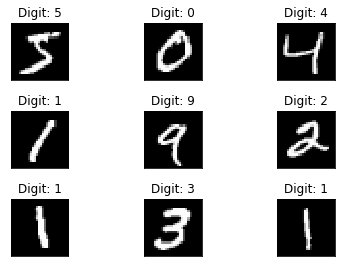

In [4]:
# display the first 9 digits

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### reformat training and testing images

In [5]:
# check out (again) dimensions and types of mnist data
print('Training images shape: ', train_images.shape)
print('Training pixel type:   ', type(train_images[0][0][0]))
print('Testing images shape:  ', test_images.shape)
print('Testing pixel type:    ', type(test_images[0][0][0]))

Training images shape:  (60000, 28, 28)
Training pixel type:    <class 'numpy.uint8'>
Testing images shape:   (10000, 28, 28)
Testing pixel type:     <class 'numpy.uint8'>


In [6]:
# number of images
Ntr = train_images.shape[0]
Nts = test_images.shape[0]

# image shape
szx = train_images.shape[1]
szy = train_images.shape[2]

# need to reshape the 28x28 training/testing images as vectors
train_images_vec = train_images.reshape((Ntr, szx * szy))
test_images_vec = test_images.reshape(  (Nts, szx * szy))

# deciding to normalize the pixels to 0..1 and recase as float32
train_images_vec = train_images_vec.astype('float32') / 255
test_images_vec = test_images_vec.astype('float32') / 255

# display new input dimensions/type
print('New training images shape: ', train_images_vec.shape)
print('New training pixel type:   ', type(train_images_vec[0][0]))
print('New testing images shape:  ', test_images_vec.shape)
print('New testing pixel type:    ', type(test_images_vec[0][0]))

New training images shape:  (60000, 784)
New training pixel type:    <class 'numpy.float32'>
New testing images shape:   (10000, 784)
New testing pixel type:     <class 'numpy.float32'>


### reformat training and testing labels

In [7]:
# check out dimensions and types of mnist data
print('Training labels shape: ', train_labels.shape)
print('Training labels type:  ', type(train_labels[0]))
print()

# check out what the first 9 labels look like
print("First 9 training labels as labels:\n", train_labels[:9])

Training labels shape:  (60000,)
Training labels type:   <class 'numpy.uint8'>

First 9 training labels as labels:
 [5 0 4 1 9 2 1 3 1]


In [8]:
from tensorflow.keras.utils import to_categorical

# also need to categorically encode the labels as "one hot"

train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

print("First 9 training labels as one-hot encoded vectors:\n", train_labels_onehot[:9])

First 9 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
# display new output dimensions/type
print('New training labels shape (one hot): ', train_labels_onehot.shape)
print('New training labels type (one hot):  ', type(train_labels_onehot[0][0]))

New training labels shape (one hot):  (60000, 10)
New training labels type (one hot):   <class 'numpy.float32'>


# define and train neural network

In [10]:
# import tools for basic keras networks 
from tensorflow.keras import models
from tensorflow.keras import layers

nout = 10

# create architecture of simple neural network model
# input layer  : 28*28 = 784 input nodes
# output layer : 10 (nout) output nodes
network = models.Sequential()
network.add(layers.Dense(nout, 
                         activation='sigmoid', 
                         input_shape=(szx * szy,)))

# print a model summary
print(network.summary())
print()
for layer in network.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print()
for layer in network.layers:
    print(layer.get_config())
print()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None

layer name : dense | input shape : (?, 784) | output shape : (?, 10)

{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 784), 'dtype': 'float32', 'units': 10, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint':

In [11]:
# compile network
network.compile(optimizer='sgd', 
                loss='mean_squared_error', 
                metrics=['accuracy'])

# now train the network
history = network.fit(train_images_vec, 
                      train_labels_onehot, 
                      verbose=True, 
                      validation_split=.1, 
                      epochs=20, 
                      batch_size=128)
print('Done training!')
print()

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 16us/sample - loss: 0.1511 - acc: 0.0853 - val_loss: 0.1083 - val_acc: 0.1438
Epoch 2/20
54000/54000 [==============================] - 1s 14us/sample - loss: 0.1005 - acc: 0.1911 - val_loss: 0.0943 - val_acc: 0.2745
Epoch 3/20
54000/54000 [==============================] - 1s 14us/sample - loss: 0.0922 - acc: 0.3164 - val_loss: 0.0890 - val_acc: 0.3963
Epoch 4/20
54000/54000 [==============================] - 1s 14us/sample - loss: 0.0880 - acc: 0.4154 - val_loss: 0.0853 - val_acc: 0.4752
Epoch 5/20
54000/54000 [==============================] - 1s 15us/sample - loss: 0.0847 - acc: 0.4758 - val_loss: 0.0822 - val_acc: 0.5187
Epoch 6/20
54000/54000 [==============================] - 1s 13us/sample - loss: 0.0819 - acc: 0.5114 - val_loss: 0.0792 - val_acc: 0.5485
Epoch 7/20
54000/54000 [==============================] - 1s 14us/sample - loss: 0.0791 - acc: 0.5374 - val_loss: 0.0

In [12]:
# test network
test_loss, test_acc = network.evaluate(test_images_vec, 
                                       test_labels_onehot, 
                                       verbose=True)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 19us/sample - loss: 0.0553 - acc: 0.7244
test_acc: 0.7244


# some pieces needed to complete Homework 3

In [13]:
# get learned network weights and biases

W = network.layers[0].get_weights()[0]     # weights input to hidden
B = network.layers[0].get_weights()[1]     # bias to hidden

print('W {} | B {}'.format(W.shape, B.shape))

W (784, 10) | B (10,)


In [14]:
# model predictions (all 10000 test images)
out = network.predict(test_images_vec)

# model predictions (a single test image)
example = test_images_vec[123]
print(example.shape)

# vector passed to network.predict must be (?, 784)
example = example.reshape((1,example.shape[0]))
print(example.shape)

(784,)
(1, 784)


In [15]:
#########################################################################################
##
## Homework 3 Solution Area
##

## Q1. The original MNIST test_labels numpy array contains the digit value associated
## with the corresponding digit image (test_images). The output from the network (from
## out = network.predict(test_images_vec) above) contains the activations of the 10
## output nodes for every test image presented to the network. Write a function that
## takes the (10000,10) numpy array of output (of type float) activations and returns a 
## (10000,) numpy array of discrete digit classification by the network (of type int).
## Specifically, create a test_decisions numpy array of the same size and type as the
## MNIST test_labels array you started with. Whereas test_labels shows the correct
## answer, test_decisions shows the ultimate decision by the network. Below you will use 
## both arrays to pull out test images that the network classifies correctly vs. incorrectly.
##
## To turn a numpy array of continuous output activations into a discrete digit classification,
## just take the maximum output as the "winner" that "takes all", determining the classification.
##
## In your function, feel free to use for loops. Here, we are looking to see that you understand
## how to use the outputs generated by the network, not whether you can program using the
## most efficient Python style.

### INSERT Q1 SOLUTION HERE ###

out_max = np.amax(out,axis=1,keepdims=False)

test_decisions = np.zeros((len(out_max),1))
for idx in range(len(out_max)):
    test_decisions[idx,0] = np.where(out[idx,:] == out_max[idx])[0][0]

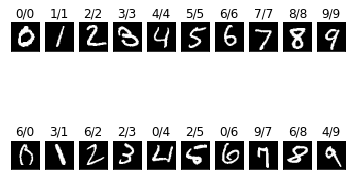

In [16]:
##
## Q2. Comparing the correct answers (test_labels) and network classifications (test_decisions),
## for each digit 0..9, find one test image (test_image) that is classified by the network
## correctly and one test image that is classified by the network incorrectly. 
##
## Create a 2x10 plot of digit images (feel free to adapt the code above that uses subplot), with a 
## column for each digit 0..9 with the first row showing examples correctly classified (one example 
## for each digit) and the second row showing the examples incorrectly classified (one example 
## for each digit). Each subplot title should show the answer and the classification response 
## (e.g., displaying 4/2 as the title, if the correct answer is 4 and the classification was 2).
##

### INSERT Q2 SOLUTION HERE ###
test_labelsRE = np.reshape(test_labels, (10_000, 1))
test_decisionsRE = np.reshape(test_decisions, (10_000, 1))

#1) find out which values are the same
res_comp = test_labelsRE==test_decisionsRE

#2) get the index of the same values?
np.where((res_comp) == True) # or np.where(a==b)

# Adding on to the previous question, is there a way for me to return 1 if the values are the same and 0 otherwise
res_comp_bool = (res_comp).astype(int)
##########################################################################################
true_dict = {x: -1 for x in list(range(10))}
false_dict = {x: -1 for x in list(range(10))}

true_count = 0
false_count = 0
while false_count+true_count<20:
    for idx in range(len(res_comp)):
        if res_comp[idx]==True and true_count<10:
            if true_dict[test_labelsRE[idx][0]]==-1:
                true_dict[test_labelsRE[idx][0]] = idx
                true_count += 1
        elif res_comp[idx]==False and false_count<10:
            if false_dict[test_labelsRE[idx][0]]==-1:
                false_dict[test_labelsRE[idx][0]] = idx
                false_count += 1
##########################################################################################
fig = plt.figure()
for i in range(20):
    plt.subplot(2,10,i+1)
    #plt.tight_layout() #Turning this off shows all 20, but the spacing is cancer with it off
    
    if i<10:
        img_idx = true_dict[i]
    elif i<20:
        img_idx = false_dict[i-10]
    
    plt.imshow(test_images[img_idx], cmap='gray', interpolation='none')
    plt.title(f"{np.int16(test_decisions[img_idx,0]).item()}/{test_labels[img_idx]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
##
## Q3. Create "images" of the connection weight adapting the code used to display
## the actual digit images. There should be 10 weight images, an image for each
## set of weight connecting the input layer (784 inputs) to each output node.
## You will want to reshape the (784,1) vector of weights to a (28,28) image and
## display the result using imshow()

### INSERT Q3 SOLUTION HERE ###

In [ ]:
##
## Q4. Use the weight matrix (W), bias vector (B), and activation function (simple sigmoid)
## to reproduce in your own code the outputs (out) generated by the network (from
## this out = network.predict(test_images_vec))
##
## The simple sigmoid activation function is defined as follows:
## f(x) = 1 / (1+exp(-x))
##
## Confirm that your output vectors and the keras-produced output vectors are the same
## (within some small epsilon since floating point calculations will often not come out
## exactly the same on computers).
##

### INSERT Q4 SOLUTION HERE ###